In [14]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [15]:

class Stimulus:
    def __init__(self, stimulus_type="normal", t_stimulus=100, mu=0, sigma=1, scale=1):
        self.stimulus_type = stimulus_type
        self.t_stimulus = t_stimulus
        self.mu = mu
        self.sigma = sigma
        self.scale = scale

        if self.stimulus_type == "gaussian":
            self.norm_distr = stats.norm(mu, sigma)
        if self.stimulus_type == "changing":
            self.old_t = self.t_stimulus

    def get_stimulus(self,t):
        """
        returns the stimulus at input time t
        """
        if (self.stimulus_type == "normal") or (self.stimulus_type == "changing"):
            if t == self.t_stimulus:
                return 1
            else:
                return 0
        elif self.stimulus_type == "gaussian":
            if abs(self.t_stimulus - t) < 3*self.sigma:
                return self.norm_distr.pdf(t) * self.scale
            else:
                return 0
            
    def set_t_stimulus(self):
        """
        sets the time of stimulus to a random value around the original stimulus time
        """
        if self.stimulus_type=="changing":
            self.t_stimulus = self.old_t + np.random.randint(-10,10)


class Reward:
    def __init__(self, reward_type="normal", t_reward=200, mu=0, sigma=1, scale=1, prob= 1):
        self.reward_type = reward_type
        self.t_reward = t_reward
        self.mu = mu
        self.sigma = sigma
        self.scale = scale
        self.prob = prob

        if self.reward_type == "gaussian":
            self.norm_distr = stats.norm(mu, sigma)

        if self.reward_type == "changing":
            self.old_t = self.t_reward



    def get_reward(self,t):
        """
        returns the reward at input time t
        """

        if (self.reward_type == "normal") or (self.reward_type == "changing"):
            if t == self.t_reward:
                return 1 * self.scale
            else:
                return 0
        elif self.reward_type == "gaussian":
            if abs(self.t_reward - t) < 3*self.sigma:
                return self.norm_distr.pdf(t) * self.scale
            else:
                return 0
            
        elif self.reward_type == "prob":
            if (t == self.t_reward) and (self.prob > np.random.random()):
                return 1 * self.scale
            else:
                return 0
            
        elif self.reward_type == "multiple":
            if t in self.t_reward:
                return 1*self.scale
            else:
                return 0
            
    def set_t_stimulus(self):
        """
        sets the time of reward to a random value around the original reward time
        """
        if self.reward_type=="changing":
            self.t_reward = self.old_t + np.random.randint(-10,10)


    

In [16]:
def update_weights(weights, idx_tau, epsilon, delta, idx_t, stimulus):
    weights[idx_tau]+= epsilon * delta[idx_t] * stimulus.get_stimulus(idx_t - idx_tau)
    return weights

def make_predictions(predictions,weights, idx_t, stimulus):
    for idx_tau in range(idx_t):
        predictions[idx_t] += weights[idx_tau] * stimulus.get_stimulus(idx_t - idx_tau)      
    return predictions


In [17]:
def td_learning(n_trials, t_axes, epsilon, stimulus, reward):
    predictions = np.zeros(len(t_axes))
    delta = np.zeros(len(t_axes))
    weights = np.zeros(len(t_axes))
    n_axes = np.arange(0, n_trials, 1)
    res = np.zeros((n_trials, len(t_axes), 5))

    for n in range(n_trials):
        # reset all values except the weights at the begin of each trial   
        delta = np.zeros(len(t_axes))
        predictions = np.zeros(len(t_axes))
        d_predictions = np.zeros(len(t_axes))
        rewards = np.zeros(len(t_axes))
        stimuli = np.zeros(len(t_axes))
        stimulus.set_t_stimulus() # for making random time of stimulus for every trial if stimulus type == changing
        reward.set_t_stimulus() # for making random time of random for every trial if reward type == changing
        
        #first calculate predictions for all timepoints
        for idx_t,t in enumerate(t_axes):
            stimuli[idx_t] = stimulus.get_stimulus(t)
            predictions = make_predictions(predictions,weights, idx_t, stimulus)

            if idx_t != 0:
                d_predictions[idx_t-1] = predictions[idx_t] - predictions[idx_t-1]
        #then calculate prediction errors delta
        for idx_t,t in enumerate(t_axes):
            if t != t_axes[-1]:
                r = reward.get_reward(t)
                delta[idx_t] = r + predictions[idx_t+1] - predictions[idx_t]
                rewards[idx_t] = r
        #update the weights
        for idx_t,t in enumerate(t_axes): 
            for idx_tau in range(idx_t):
                old_weights = weights.copy()
                weights = update_weights(old_weights, idx_tau, epsilon, delta, t, stimulus) 
                     
        res[n, :,0] = stimuli
        res[n, :,1] = rewards        
        res[n, :,2] = predictions
        res[n, :,3] = d_predictions
        res[n, :,4] = delta
    return t_axes, n_axes, res

In [18]:
def plot_epsilons(X,Y,Z, epsilon):
    ax = plt.figure().add_subplot(projection='3d')
    X_2, Y_2 = np.meshgrid(X, Y)
    epsilon=np.round(epsilon,1)

    surf = ax.plot_surface(X_2, Y_2, Z[:,:,4])

    ax.view_init(30, -60) 
    plt.title("Delta over time and trials with epsilon = {}".format(epsilon))
    plt.xlabel("time")
    plt.ylabel("trial")
    ax.set_zlabel("delta")
    plt.show()

    labels = ["u","r", "v", "delta_v","delta"]

    fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(8,8))
    
    for trial_idx, trial in enumerate([0,-1]):
        for parameter in range(5):
            ax[parameter,trial_idx].plot(X, Z[trial,:,parameter])
            if trial_idx == 0:
                ax[parameter,trial_idx].set_ylabel(labels[parameter])
            if parameter == 0:
                ax[parameter,trial_idx].set_xlabel("time")

            
    fig.set()
    fig.suptitle("Parameters over time for first and last trial with epsilon = {}".format(epsilon))
    fig.supxlabel("First trial")
    


In [19]:
def plot(X,Y,Z, title):
    # general plotting class
    %matplotlib inline
    ax = plt.figure().add_subplot(projection='3d')
    X_2, Y_2 = np.meshgrid(X, Y)

    surf = ax.plot_surface(X_2, Y_2, Z[:,:,4])

    ax.view_init(30, -60) 
    plt.title("Delta over time and trials")
    plt.xlabel("time")
    plt.ylabel("trial")
    ax.set_zlabel("delta")
    plt.show()

    labels = ["u","r", "v", "delta_v","delta"]

    fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(8,8))

    for trial_idx, trial in enumerate([0,-1]):
        for parameter in range(5):
            ax[parameter,trial_idx].plot(X, Z[trial,:,parameter])
            if trial_idx == 0:
                ax[parameter,trial_idx].set_ylabel(labels[parameter])
            if parameter == 0:
                ax[parameter,trial_idx].set_xlabel("time")

            
    fig.set()
    fig.suptitle(title)
    fig.supxlabel("First trial vs Last trial");

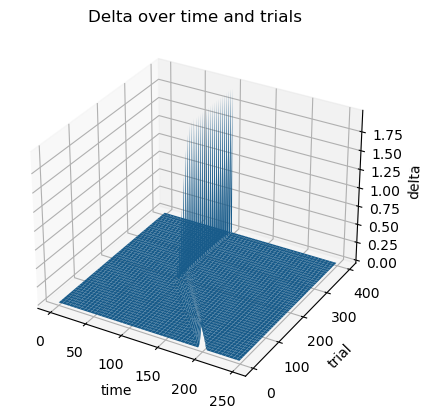

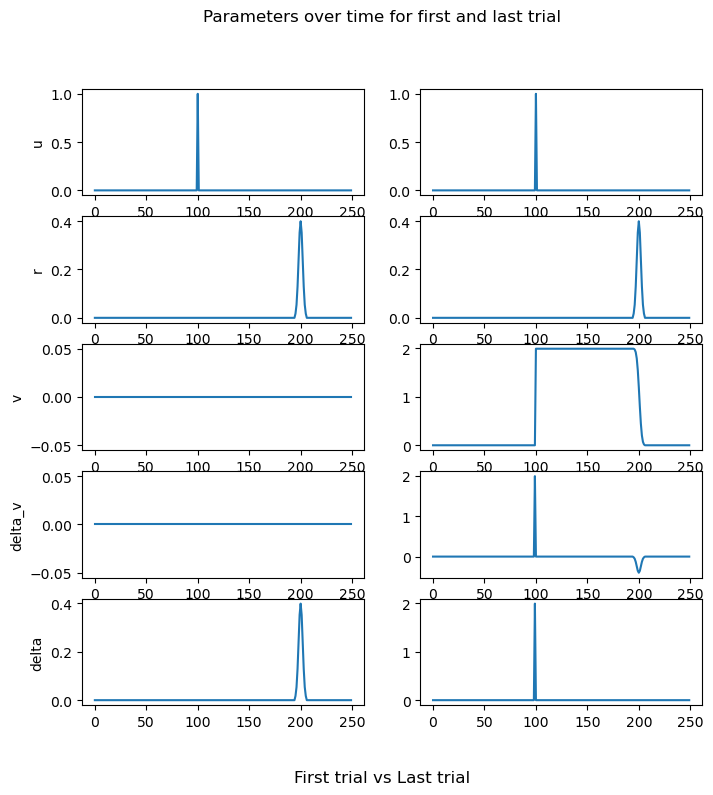

In [20]:
#replicating figure from textbook
t_steps = 1
trial_time = 250
t_axes = np.arange(0, trial_time, t_steps)
n_trials = 400
epsilon = 0.5

stimulus_type = "normal" # "gaussian" or "normal"
reward_type = "gaussian" # "gaussian" or "normal"
t_stimulus = 100
t_reward = 200

reward = Reward(reward_type=reward_type, t_reward=t_reward, mu=t_reward, sigma=2, scale=2)
stimulus = Stimulus(stimulus_type=stimulus_type, t_stimulus=t_stimulus, mu=t_stimulus, sigma=1, scale=1)

X, Y, Z = td_learning(n_trials, t_axes, epsilon, stimulus, reward)

title = "Parameters over time for first and last trial"
plot(X,Y,Z,title)



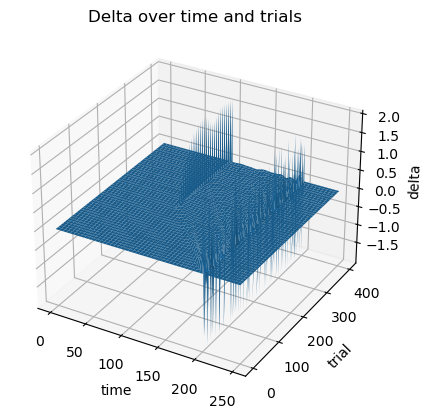

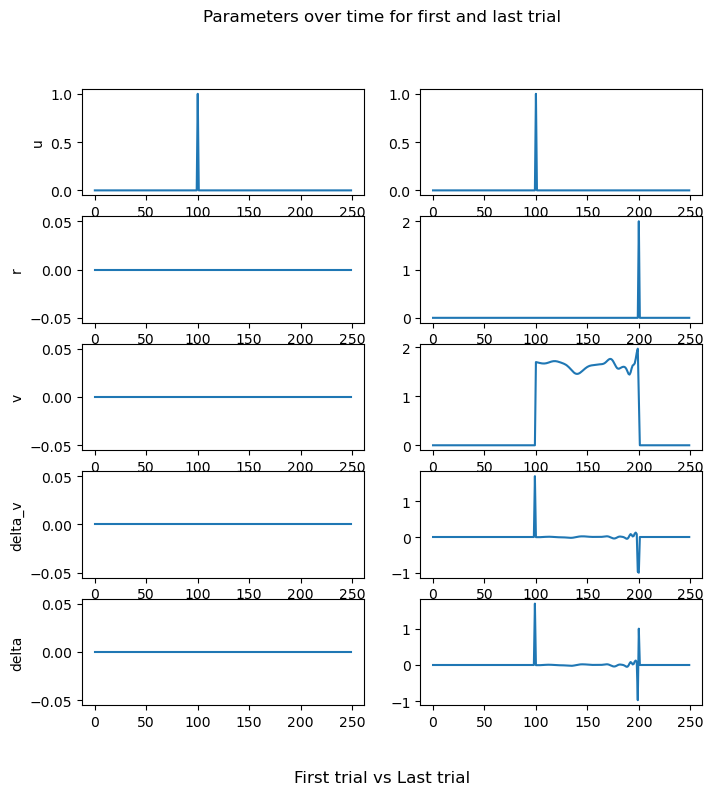

In [21]:
#probabilistic reward
t_steps = 1
trial_time = 250
t_axes = np.arange(0, trial_time, t_steps)
n_trials = 400
epsilon = 0.5

stimulus_type = "normal" # "gaussian" or "normal"
reward_type = "prob" # "gaussian" or "normal" or "prob"
t_stimulus = 100
t_reward = 200

reward = Reward(reward_type=reward_type, t_reward=t_reward, mu=t_reward, sigma=2, scale=2, prob = 0.8)
stimulus = Stimulus(stimulus_type=stimulus_type, t_stimulus=t_stimulus, mu=t_stimulus, sigma=1, scale=1)

X, Y, Z = td_learning(n_trials, t_axes, epsilon, stimulus, reward)

title = "Parameters over time for first and last trial"
plot(X,Y,Z,title)

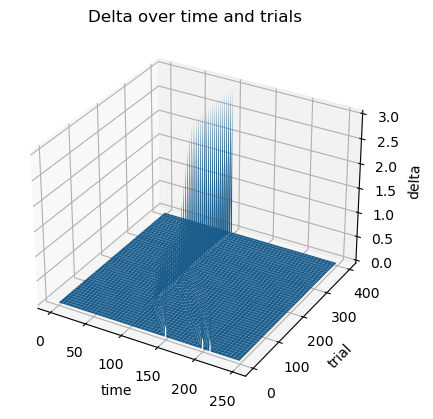

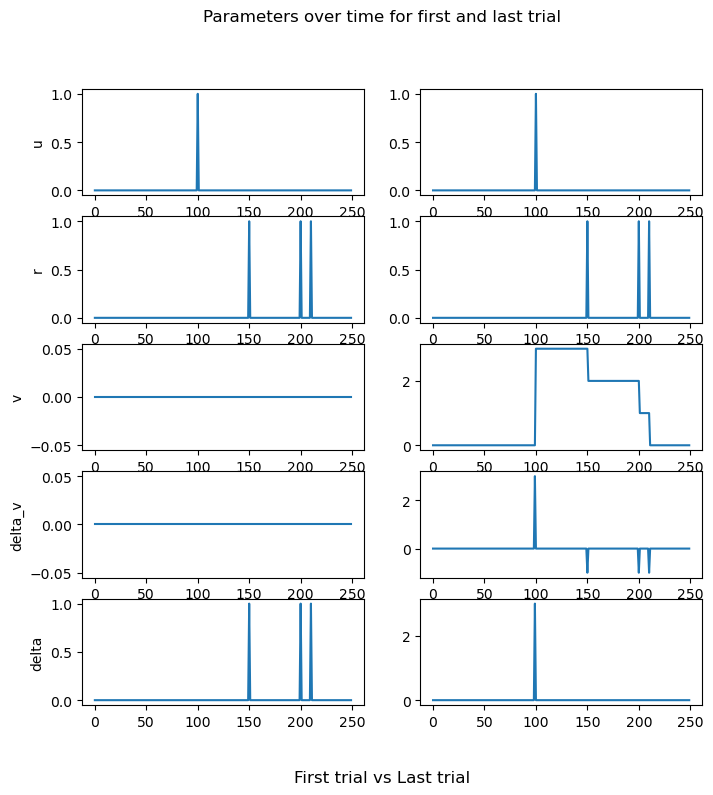

In [22]:
#multiple rewards
t_steps = 1
trial_time = 250
t_axes = np.arange(0, trial_time, t_steps)
n_trials = 400
epsilon = 0.5

stimulus_type = "normal" # "gaussian" or "normal"
reward_type = "multiple" # "gaussian" or "normal" or "prob" or "multiple"
t_stimulus = 100
t_reward = [150,200, 210]

reward = Reward(reward_type=reward_type, t_reward=t_reward, mu=t_reward, sigma=2, scale=1, prob = 0.8)
stimulus = Stimulus(stimulus_type=stimulus_type, t_stimulus=t_stimulus, mu=t_stimulus, sigma=1, scale=1)

X, Y, Z = td_learning(n_trials, t_axes, epsilon, stimulus, reward)

title = "Parameters over time for first and last trial"
plot(X,Y,Z,title)

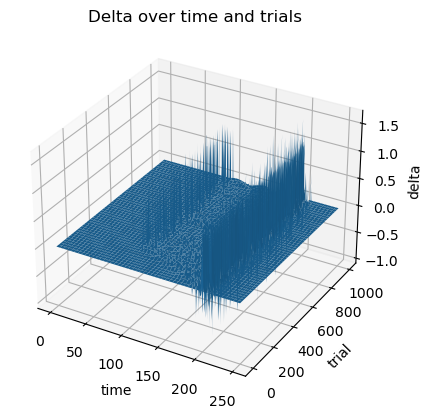

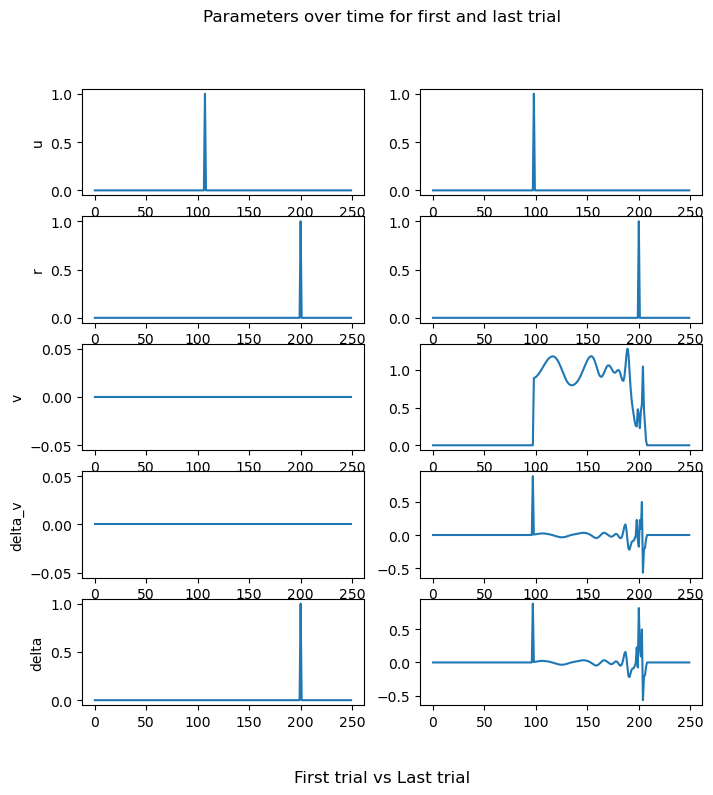

In [23]:
#differing timing of stimuli
t_steps = 1
trial_time = 250
t_axes = np.arange(0, trial_time, t_steps)
n_trials = 1000
epsilon = 0.5

stimulus_type = "changing" # "gaussian" or "normal" or "changing"
reward_type = "normal" # "gaussian" or "normal" or "prob" or "multiple"
t_stimulus = 100
t_reward = 200

reward = Reward(reward_type=reward_type, t_reward=t_reward, mu=t_reward, sigma=2, scale=1, prob = 0.8)
stimulus = Stimulus(stimulus_type=stimulus_type, t_stimulus=t_stimulus, mu=t_stimulus, sigma=1, scale=1)

X, Y, Z = td_learning(n_trials, t_axes, epsilon, stimulus, reward)

title = "Parameters over time for first and last trial"
plot(X,Y,Z,title)

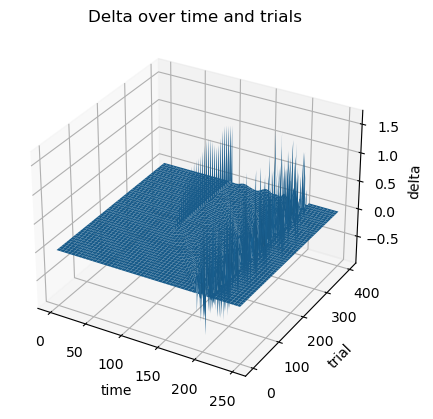

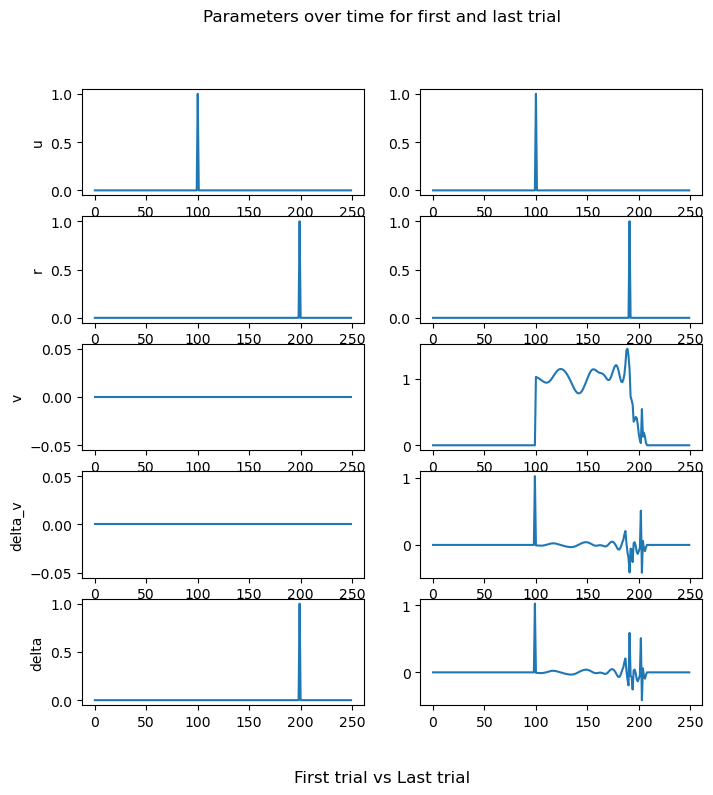

In [24]:
#differing timing of reward
t_steps = 1
trial_time = 250
t_axes = np.arange(0, trial_time, t_steps)
n_trials = 400
epsilon = 0.5

stimulus_type = "normal" # "gaussian" or "normal" or "changing"
reward_type = "changing" # "gaussian" or "normal" or "prob" or "multiple" or "changing"
t_stimulus = 100
t_reward = 200

reward = Reward(reward_type=reward_type, t_reward=t_reward, mu=t_reward, sigma=2, scale=1, prob = 0.8)
stimulus = Stimulus(stimulus_type=stimulus_type, t_stimulus=t_stimulus, mu=t_stimulus, sigma=1, scale=1)

X, Y, Z = td_learning(n_trials, t_axes, epsilon, stimulus, reward)

title = "Parameters over time for first and last trial"
plot(X,Y,Z,title)

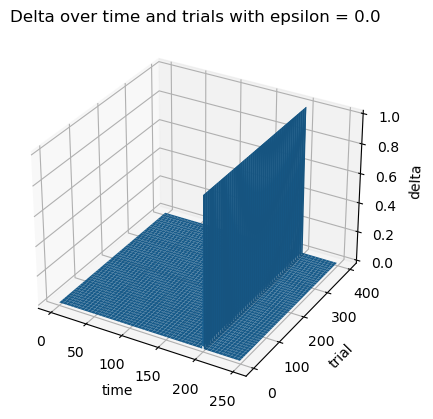

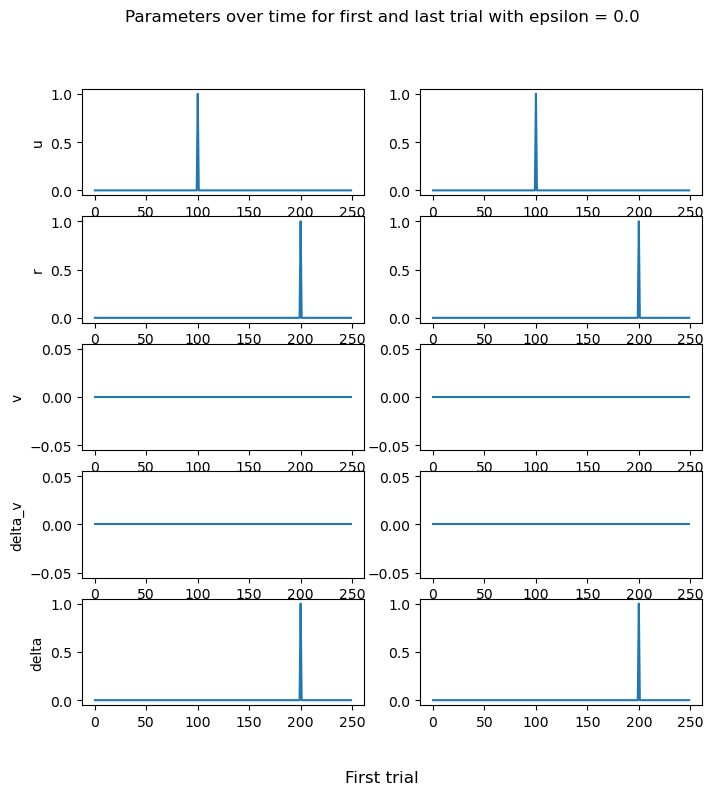

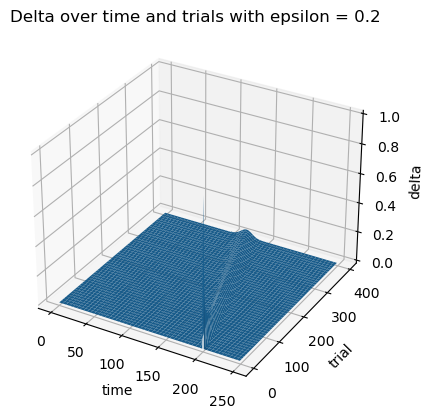

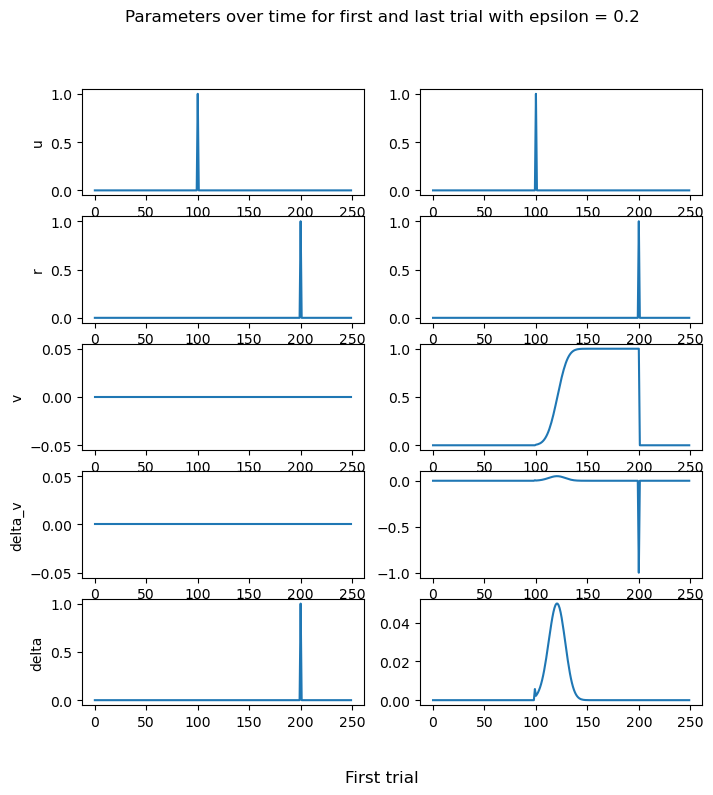

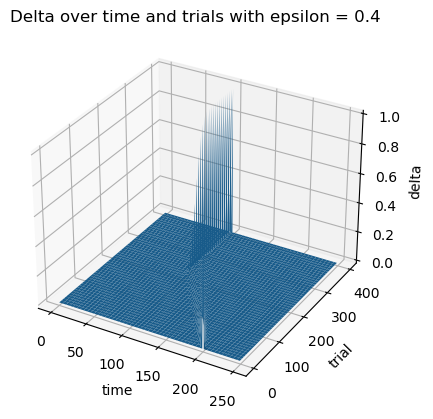

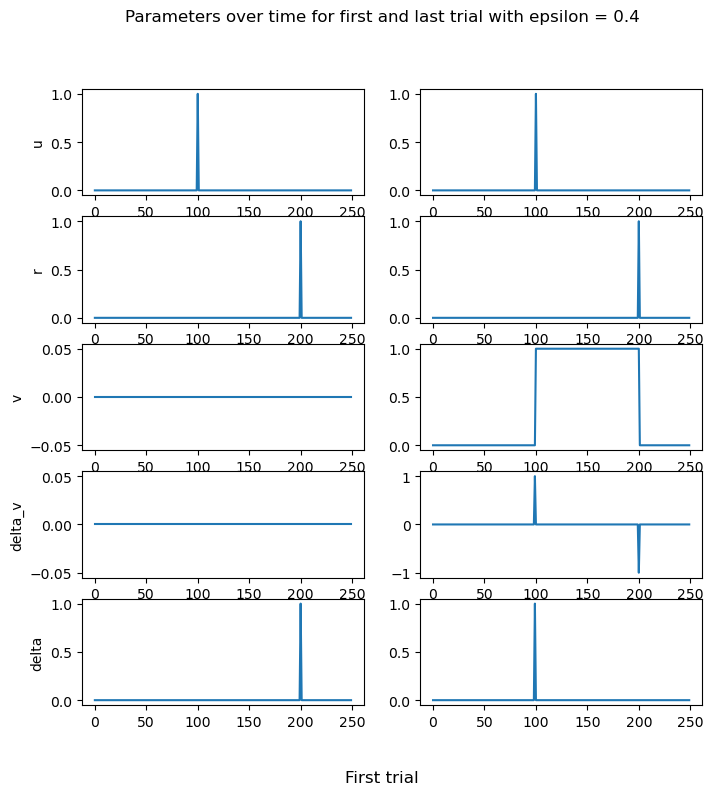

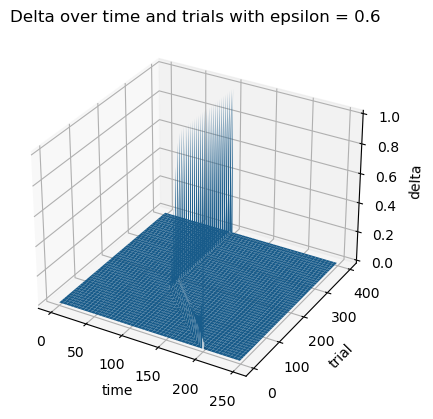

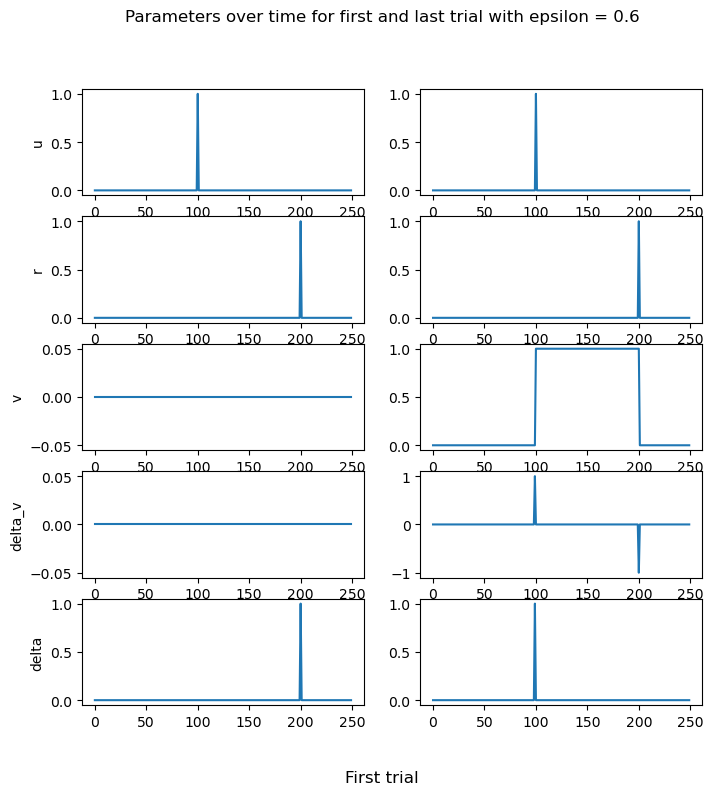

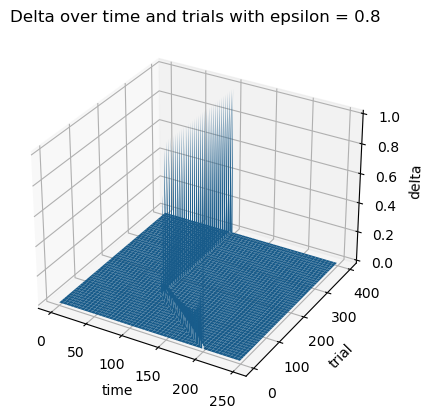

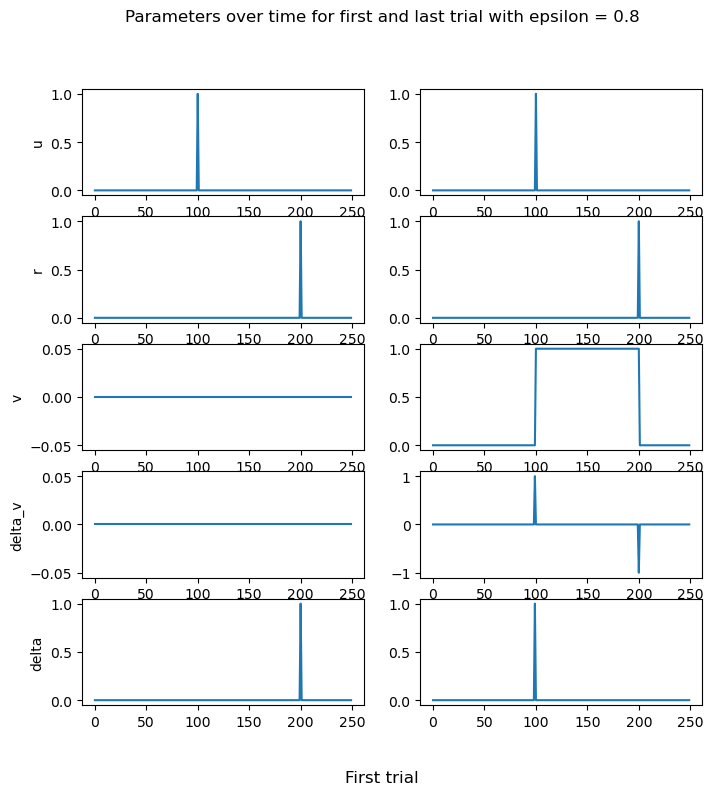

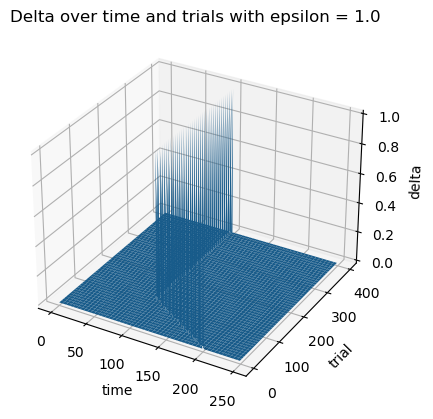

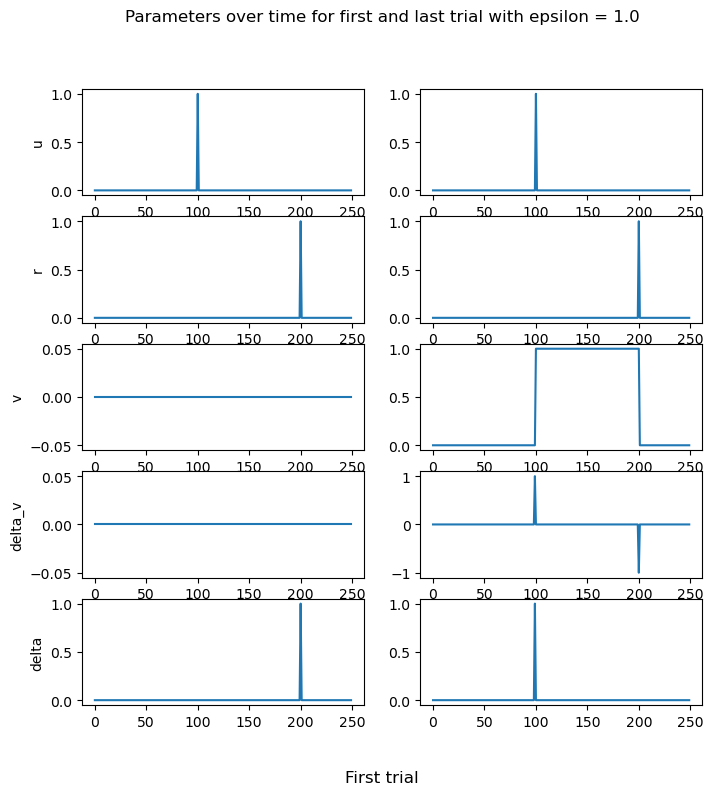

In [25]:
#plots for different epsilons
t_steps = 1
trial_time = 250
t_axes = np.arange(0, trial_time, t_steps)
n_trials = 400
epsilon = 0.9

stimulus_type = "normal" # "gaussian" or "normal"
reward_type = "normal" # "gaussian" or "normal"
t_stimulus = 100
t_reward = 200

reward = Reward(reward_type="normal", t_reward=t_reward, mu=t_reward, sigma=1, scale=1)
stimulus = Stimulus(stimulus_type="normal", t_stimulus=t_stimulus, mu=0, sigma=1, scale=1)

for epsilon in np.linspace(0,1,6):
    t_axes, n_axes, res = td_learning(n_trials, t_axes, epsilon, stimulus, reward)
    
    plot_epsilons(t_axes,n_axes,res, epsilon)
